In [1]:
# pip install kneed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import *
from kneed import KneeLocator
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
json = pd.read_json('tracks.json')

In [4]:
pd.set_option('display.max_columns', None)
json.head()

,id,id_artist,title,featured_artists,primary_artist,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,char_per_tok,avg_token_per_clause,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,album_name,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,id_album,lyrics,streams@1month
0,TR934808,ART04205421,​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...","['bitch', 'fuck', 'porno', 'pussy']",2021.0,4.0,2.0,102.0,911.0,4.170455,8.133929,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",186522
1,TR760029,ART04205421,POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...","['escort', 'negro', 'sex', 'sexy', 'shit']",2020.0,3.0,6.0,56.0,675.0,4.280851,12.500000,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",194313
2,TR916821,ART04205421,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']","['bastardo', 'bitch', 'bitches', 'cock', 'fuck']",2021.0,2.0,19.0,88.0,758.0,4.075251,8.422222,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590,FOREVER AND EVER,2021-04-09,album,1.0,1.0,193544.0,1.0,39.0,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",63750
3,TR480968,ART04205421,CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...","['fuck', 'porno', 'shit']",2019.0,3.0,8.0,37.0,382.0,4.023881,6.701754,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067,OKAY OKAY 2,2025-05-16,single,1.0,2.0,169000.0,1.0,47.0,ALB730959,Designer sui vestiti penso di essere un outlet...,41473
4,TR585039,ART04205421,LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,1,0,['cazzo'],[],2020.0,5.0,29.0,48.0,429.0,3.922857,8.411765,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407,FOREVER,2020-05-28,album,1.0,8.0,194779.0,1.0,41.0,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",30553


In [5]:
# Droppo le colonne che non ci servono e lascio solo le feature acustiche per il clustering
json_copy = json.copy()

json_copy.drop(columns=['id', 'id_artist', 'title', 'featured_artists', 'primary_artist', 'language', 'album', 'swear_IT', 'swear_EN',
            'swear_IT_words', 'swear_EN_words', 'year', 'month', 'day', 'n_sentences', 'n_tokens', 'char_per_tok',
              'avg_token_per_clause', 'album_name', 'album_release_date', 'album_type', 'disc_number', 'track_number',
              'explicit', 'popularity', 'duration_ms', 'id_album', 'lyrics', 'streams@1month'], inplace=True)

In [6]:
json_copy.head()

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness
0,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675
1,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595
2,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590
3,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067
4,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407


## Feature Audio Musicali

Queste sono le **feature audio** estratte dalle tracce musicali, comunemente utilizzate nell'analisi musicale e nel Music Information Retrieval (MIR).

### Feature Spettrali

- **BPM (Beats Per Minute)**: Il tempo o velocità della traccia musicale, indica quanti battiti musicali ci sono in un minuto.

- **Rolloff**: La frequenza di roll-off spettrale, ovvero la soglia sotto la quale si trova una certa percentuale (tipicamente 85%) dell'energia spettrale totale. Misura la forma dello spettro.

- **Flux**: Il flusso spettrale, misura quanto velocemente cambia lo spettro di frequenza tra frame consecutivi. Alto flux indica cambiamenti rapidi nel timbro.

- **Spectral Complexity**: Misura la complessità dello spettro di frequenza, legata alla ricchezza armonica e alla densità spettrale del suono.

### Feature Temporali e Timbriche

- **RMS (Root Mean Square)**: L'energia o volume medio del segnale audio per ogni frame. Rappresenta il livello sonoro.

- **Flatness**: La planarità spettrale (spectral flatness), misura quanto uno spettro è simile al rumore bianco. Valori alti indicano suoni simili a rumore, valori bassi indicano suoni tonali.

### Feature Armoniche

- **Pitch**: L'altezza tonale percepita del suono, la frequenza fondamentale dominante.

- **Loudness**: L'intensità sonora percepita, correlata all'energia ma pesata secondo la percezione umana.

---

Queste feature sono tipicamente estratte usando librerie come **librosa**, **Essentia** o simili, e vengono utilizzate per task di classificazione musicale, analisi del mood, riconoscimento di generi e clustering.


In [7]:
columns = json_copy.columns

# Prima del dropna/normalizzazione, salva gli indici originali delle righe valide
indici_validi = ~json_copy.isnull().any(axis=1)
indici_orig = json_copy.index[indici_validi]

# Uso la min-max normalization
scaler = MinMaxScaler()
array_norm = scaler.fit_transform(json_copy.loc[indici_orig])
json_norm = pd.DataFrame(array_norm, columns=columns, index=indici_orig)

# Droppo le righe con valori nulli perchè non sono classificabili in una sottocategoria musicale e inoltre
# il clustering non accetta valori nulli
# Rimuove righe che contengono almeno un NaN
array_norm = array_norm[~np.isnan(array_norm).any(axis=1)]

# L'output della trasformazione è un array, quindi sotto ricreo il df (con il columns che mi sono salvato all'inizio)
json_norm = pd.DataFrame(array_norm, columns=columns)

json_norm.head()

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness
0,0.111087,0.335316,0.751828,0.287184,0.798114,0.420022,0.578804,0.218035
1,0.102315,0.391209,0.701737,0.324811,0.633842,0.475461,0.473875,0.261868
2,0.108669,0.235930,0.716723,0.410355,0.757691,0.440626,0.622173,0.359485
3,0.150745,0.133903,0.803682,0.316932,0.861217,0.233502,0.747457,0.250241
4,0.067669,0.196093,0.564480,0.380929,0.839546,0.599373,0.393699,0.309230


In [8]:
sse_list = []
sil_list = []
k_values = range(2, 21)

for k in tqdm(k_values, desc="Clustering"):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(array_norm)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(array_norm, kmeans.labels_))

kn = KneeLocator(k_values, sse_list, curve='convex', direction='decreasing')
elbow_k = kn.elbow
print("Numero ottimale di cluster (k) secondo il metodo del gomito:", elbow_k)

Clustering: 100%|██████████| 19/19 [00:57<00:00,  3.01s/it]

Numero ottimale di cluster (k) secondo il metodo del gomito: 6


In [9]:
# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2)

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sse_list))], y=sse_list, line=dict(color='#FFA500'), mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sil_list))], y=sil_list, line=dict(color='black'), mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="OD: SSE and Silhouette Score",
                  showlegend=False, title_x=0.5,font=dict(
        family="Arial",  # Font family
        size=20,         # Font size for all text elements
        color="Black"
                      ))    # Font color for all text elements)

# Mostra il grafico
fig.show()

In [10]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=1000, max_iter=100, random_state=42)
kmeans.fit(array_norm)

KMeans(max_iter=100, n_clusters=6, n_init=1000, random_state=42)

In [11]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(array_norm, kmeans.labels_))

labels (array([0, 1, 2, 3, 4, 5], dtype=int32), array([1993, 2895, 1329, 2434, 2185,  266]))
sse 339.9380695840246
silhouette 0.19140459376557514


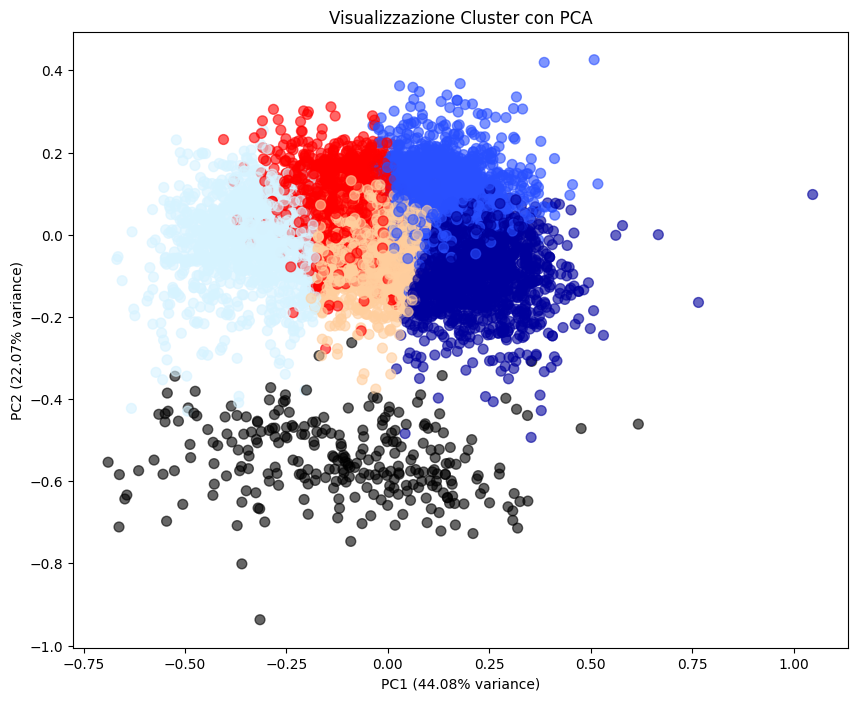

In [12]:
# Applico PCA per visualizzazione
pca = PCA(n_components=2)
array_pca = pca.fit_transform(array_norm)

labels = kmeans.labels_

# Plotto i cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(array_pca[:, 0], array_pca[:, 1], 
                      c=labels, cmap='flag', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Visualizzazione Cluster con PCA')
plt.show()

In [13]:
# Calcola le medie delle feature per ogni cluster
json_norm['cluster'] = labels

# Statistiche per cluster
cluster_means = json_norm.groupby('cluster').mean()
print(cluster_means)

              bpm   rolloff      flux       rms  flatness  \
cluster                                                     
0        0.077305  0.176421  0.695727  0.323252  0.863028   
1        0.078667  0.193267  0.624844  0.334189  0.872405   
2        0.082212  0.173680  0.610207  0.180237  0.843657   
3        0.083477  0.154278  0.683980  0.460729  0.874034   
4        0.079156  0.231752  0.642789  0.432069  0.831023   
5        0.072662  0.206285  0.644473  0.306146  0.175150   

         spectral_complexity     pitch  loudness  
cluster                                           
0                   0.347378  0.645995  0.257862  
1                   0.458354  0.506905  0.264243  
2                   0.246196  0.538219  0.120890  
3                   0.464151  0.631610  0.402468  
4                   0.633072  0.511683  0.365343  
5                   0.417574  0.552394  0.243375  


In [14]:
mood_labels = {
    0: "Introspective Rap",
    1: "Lo-Fi Hip Hop/Chill Rap", 
    2: "Cloud Rap/Experimental",
    3: "Club/Party Rap",
    4: "Trap/Drill",
    5: "Boom Bap/Classic Hip Hop"
}

# Aggiungi le etichette al tuo DataFrame
json_norm['mood'] = json_norm['cluster'].map(mood_labels)

In [15]:
json_norm.head()

,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,cluster,mood
0,0.111087,0.335316,0.751828,0.287184,0.798114,0.420022,0.578804,0.218035,0,Introspective Rap
1,0.102315,0.391209,0.701737,0.324811,0.633842,0.475461,0.473875,0.261868,1,Lo-Fi Hip Hop/Chill Rap
2,0.108669,0.235930,0.716723,0.410355,0.757691,0.440626,0.622173,0.359485,3,Club/Party Rap
3,0.150745,0.133903,0.803682,0.316932,0.861217,0.233502,0.747457,0.250241,0,Introspective Rap
4,0.067669,0.196093,0.564480,0.380929,0.839546,0.599373,0.393699,0.309230,4,Trap/Drill


In [16]:
json_finale = json.join(json_norm[['mood']], how='left')

In [17]:
json_finale.head()

,id,id_artist,title,featured_artists,primary_artist,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,char_per_tok,avg_token_per_clause,bpm,rolloff,flux,rms,flatness,spectral_complexity,pitch,loudness,album_name,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,id_album,lyrics,streams@1month,mood
0,TR934808,ART04205421,​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,13,6,"['cazzo', 'cesso', 'coglioni', 'figa', 'merda'...","['bitch', 'fuck', 'porno', 'pussy']",2021.0,4.0,2.0,102.0,911.0,4.170455,8.133929,135.32,2895.7767,1.4499,0.1786,0.8202,25.7148,2311.1779,17.8675,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",186522,Introspective Rap
1,TR760029,ART04205421,POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,9,12,"['cazzo', 'culo', 'frocio', 'puttana', 'sega',...","['escort', 'negro', 'sex', 'sexy', 'shit']",2020.0,3.0,6.0,56.0,675.0,4.280851,12.500000,129.37,3378.4605,1.3533,0.2020,0.6739,29.1089,1892.1924,21.4595,FOREVER AND EVER,2021-04-09,album,1.0,3.0,207761.0,1.0,46.0,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",194313,Lo-Fi Hip Hop/Chill Rap
2,TR916821,ART04205421,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,16,12,"['bastardo', 'cazzo', 'culo', 'merda', 'troia']","['bastardo', 'bitch', 'bitches', 'cock', 'fuck']",2021.0,2.0,19.0,88.0,758.0,4.075251,8.422222,133.68,2037.4847,1.3822,0.2552,0.7842,26.9762,2484.3503,29.4590,FOREVER AND EVER,2021-04-09,album,1.0,1.0,193544.0,1.0,39.0,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",63750,Club/Party Rap
3,TR480968,ART04205421,CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,8,3,"['cazzo', 'culo', 'fottere', 'merda', 'pompino...","['fuck', 'porno', 'shit']",2019.0,3.0,8.0,37.0,382.0,4.023881,6.701754,162.22,1156.3781,1.5499,0.1971,0.8764,14.2956,2984.6109,20.5067,OKAY OKAY 2,2025-05-16,single,1.0,2.0,169000.0,1.0,47.0,ALB730959,Designer sui vestiti penso di essere un outlet...,41473,Introspective Rap
4,TR585039,ART04205421,LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,1,0,['cazzo'],[],2020.0,5.0,29.0,48.0,429.0,3.922857,8.411765,105.87,1693.4542,1.0886,0.2369,0.8571,36.6951,1572.0499,25.3407,FOREVER,2020-05-28,album,1.0,8.0,194779.0,1.0,41.0,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",30553,Trap/Drill


In [18]:
# Salva come array di oggetti JSON
json_finale.to_json('tracks_moods.json', 
                   orient='records',
                   force_ascii=False,
                   indent=2)